# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)


## The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [7]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [8]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [9]:
from asl_utils import test_std_tryit
# Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [10]:
# add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])

asl.df['norm-lx'] = (asl.df['left-x']-asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['norm-rx'] = (asl.df['right-x']-asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['norm-ly'] = (asl.df['left-y']-asl.df['left-y-mean'])/asl.df['left-y-std']
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df['norm-ry'] = (asl.df['right-y']-asl.df['right-y-mean'])/asl.df['right-y-std']


features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [11]:
# add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'],asl.df['grnd-ry'])
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'],asl.df['grnd-ly'])
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']


In [12]:
# add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['delta-rx'] = asl.df['right-x'].diff()
asl.df['delta-lx'] = asl.df['left-x'].diff()
asl.df['delta-ry'] = asl.df['right-y'].diff()
asl.df['delta-ly'] = asl.df['left-y'].diff()

asl.df['delta-ly'] = asl.df['delta-ly'].fillna(0)
asl.df['delta-ry'] = asl.df['delta-ry'].fillna(0)
asl.df['delta-lx'] = asl.df['delta-lx'].fillna(0)
asl.df['delta-rx'] = asl.df['delta-rx'].fillna(0)
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']


In [28]:
# add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
asl.df['delta-lr-x']= asl.df['norm-lx']-asl.df['norm-rx']
asl.df['delta-lr-y']= asl.df['norm-ly']-asl.df['norm-ry']

df_std = asl.df.groupby('speaker').std()
df_means = asl.df.groupby('speaker').mean()

asl.df['polar-rr-mean'] = asl.df['speaker'].map(df_means['polar-rr'])
asl.df['polar-rr-std'] = asl.df['speaker'].map(df_std['polar-rr'])
asl.df['norm-polar-rr'] = (asl.df['polar-rr']-asl.df['polar-rr-mean'])/asl.df['polar-rr-std']
asl.df['polar-lr-mean'] = asl.df['speaker'].map(df_means['polar-lr'])
asl.df['polar-lr-std'] = asl.df['speaker'].map(df_std['polar-lr'])
asl.df['norm-polar-lr'] = (asl.df['polar-lr']-asl.df['polar-lr-mean'])/asl.df['polar-lr-std']
asl.df['polar-rtheta-mean'] = asl.df['speaker'].map(df_means['polar-rtheta'])
asl.df['polar-rtheta-std'] = asl.df['speaker'].map(df_std['polar-rtheta'])
asl.df['norm-polar-rtheta'] = (asl.df['polar-rtheta']-asl.df['polar-rtheta-mean'])/asl.df['polar-rtheta-std']
asl.df['polar-ltheta-mean'] = asl.df['speaker'].map(df_means['polar-ltheta'])
asl.df['polar-ltheta-std'] = asl.df['speaker'].map(df_std['polar-ltheta'])
asl.df['norm-polar-ltheta'] = (asl.df['polar-ltheta']-asl.df['polar-ltheta-mean'])/asl.df['polar-ltheta-std']

asl.df['norm-polar-rr-diff'] = asl.df['norm-polar-rr'].diff()
asl.df['norm-polar-lr-diff'] = asl.df['norm-polar-lr'].diff()
asl.df['norm-polar-rtheta-diff'] = asl.df['norm-polar-rtheta'].diff()
asl.df['norm-polar-ltheta-diff'] = asl.df['norm-polar-ltheta'].diff()

asl.df['norm-polar-rr-diff'] = asl.df['norm-polar-rr-diff'].fillna(0)
asl.df['norm-polar-lr-diff'] = asl.df['norm-polar-lr-diff'].fillna(0)
asl.df['norm-polar-rtheta-diff'] = asl.df['norm-polar-rtheta-diff'].fillna(0)
asl.df['norm-polar-ltheta-diff'] = asl.df['norm-polar-ltheta-diff'].fillna(0)
# define a list named 'features_custom' for building the training set
features_custom = ['delta-lr-x', 'delta-lr-y','norm-polar-rr','norm-polar-lr','norm-polar-rtheta',
                  'norm-polar-ltheta']
features_custom1 = ['norm-polar-rr','norm-polar-lr','norm-polar-rtheta','norm-polar-ltheta']
features_custom2 = ['delta-lr-x', 'delta-lr-y']
features_custom3 = ['norm-polar-rr-diff','norm-polar-lr-diff','norm-polar-rtheta-diff','norm-polar-ltheta-diff']
features_custom4 = ['delta-lr-x', 'delta-lr-y','norm-polar-rr-diff','norm-polar-lr-diff','norm-polar-rtheta-diff','norm-polar-ltheta-diff']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
Normalized all of the polar coordinate features(features_custom1). This alone is a great improvement from original polar features. Added a pair of new a delta features(features_custom2) representing the differentials between the left and right hands in x,y coordinates. These use the normalized x,y pairs as they performed much better compared with the ground versions. Thus features_custom contains these 6 features(the combination of features_custom1+features_custom2).

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [14]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.021s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [15]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433223


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [16]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [17]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 9, features_custom) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 9
hidden state #0
mean =  [-0.72176025 -0.76612935  0.02425832 -0.68928861  0.70105528 -0.26558482]
variance =  [ 0.02991007  0.0179546   0.08011348  0.03412389  0.00246381  0.02531215]

hidden state #1
mean =  [-0.80612295 -1.4664087  -0.39006103 -1.85276178  0.22837912 -0.24573855]
variance =  [ 0.04177202  0.00721895  0.00514723  0.00825214  0.01550733  0.00125971]

hidden state #2
mean =  [-2.27958436 -1.55621931 -0.19977964 -1.742691    0.88419687 -0.38037765]
variance =  [ 0.03146217  0.02025232  0.00521642  0.02398488  0.01823874  0.00555508]

hidden state #3
mean =  [-0.76752987  0.52640743 -0.48498295  0.18304013  0.42868977 -0.42888187]
variance =  [ 0.02913256  0.01602523  0.00779297  0.02314987  0.06962902  0.00350123]

hidden state #4
mean =  [-0.30869152 -0.92410061 -0.01686702 -0.90480175  0.50593628 -0.15155584]
variance =  [ 0.01081473  0.0076776   0.00806229  0.00112284  0.00360356  0.00805994]

hidden state #5
mean =

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [19]:
%matplotlib inline

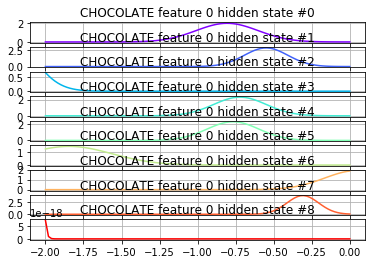

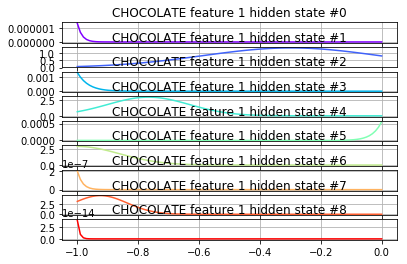

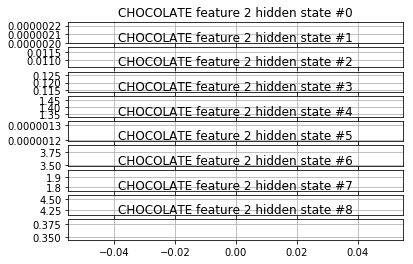

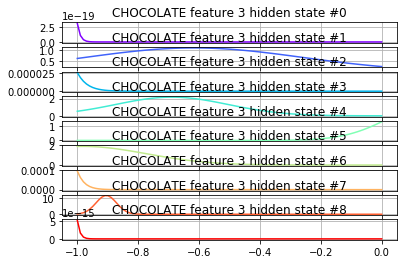

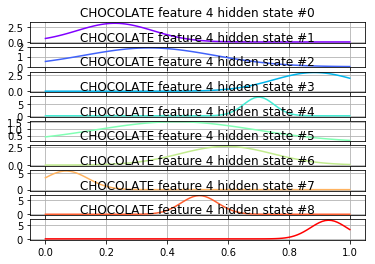

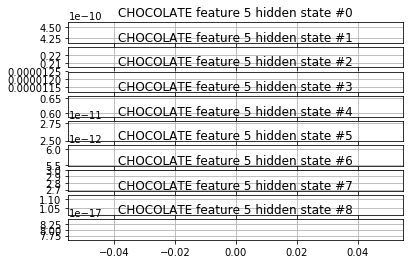

In [20]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [21]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [22]:
from sklearn.model_selection import KFold
from asl_utils import combine_sequences

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
all_sequences = training.get_all_sequences()
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [18]:
words_to_train = ['FISH','BOOK','VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [24]:
# Implement SelectorCV in my_model_selector.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    print(word)
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training \failed for {}".format(word))

FISH
Training complete for FISH with 3 states with time 0.0385224564324842 seconds
BOOK
Training complete for BOOK with 2 states with time 5.440114988940622 seconds
VEGETABLE
Training complete for VEGETABLE with 13 states with time 2.368420652985674 seconds
FUTURE
Training complete for FUTURE with 2 states with time 5.010910192136587 seconds
JOHN
Training complete for JOHN with 15 states with time 76.11929075264513 seconds


In [19]:
#Implement SelectorBIC in module my_model_selectors.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorBIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.5003204797503698 seconds
Training complete for BOOK with 7 states with time 3.4930081815018643 seconds
Training complete for VEGETABLE with 4 states with time 1.1327429359339765 seconds
Training complete for FUTURE with 6 states with time 2.1521217992782837 seconds
Training complete for JOHN with 15 states with time 34.82315726376846 seconds


In [20]:
# Implement SelectorDIC in module my_model_selectors.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 4.6531073582597315 seconds
Training complete for BOOK with 15 states with time 8.038467396601163 seconds
Training complete for VEGETABLE with 10 states with time 5.542710459163729 seconds
Training complete for FUTURE with 15 states with time 6.101846901351649 seconds
Training complete for JOHN with 15 states with time 40.740897370100726 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
CV, BIC, DIC run with feature sets custom, custom1, custom2.
For custom, BIC is overall fastest on average except for JOHN where it was 10% slower then DIC(this is the slowest, requiring 10 or more in every run as well as being ~ an order of magnitude greater in time than other words across all runs) thus best in speed. BIC also yields 3-7 hidden states(excepting JOHN) where as DIC is >10 except for FISH and CV is very low(2,3,2) but VEGETABLE also high at 13. Based on this, BIC seems best for this set of features.

For custom1, BIC is the fastest overall(only beaten again by CV for FISH).For hidden states, CV excels with 2,3,2,3,15 whereas BIC yields 2,7,3,4,15. DIC is >=10 for 4 words. In this case, CV or BIC can be argued for depending on how the size of hidden state space affects your application. 

For custom2, speed again goes to BIC across the board save FISH(to CV) and hidden states this time are in BIC's favor with JOHN at 10(lone instance it is under 14) and 3 or 4 for the others. CV has 3,4,2,3,14 for state space so in this feature set the clear winner is BIC.

It is no surprise that DIC is very slow across all experiments since it is creating many models for every iteration. Overall, without including results of future tests(WER), BIC seems the best choice if regarding all the feature sets and is surely the best for the most comprehensive set(custom).

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [29]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 89.797s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [21]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [22]:
test_set = asl.build_test(features_custom)
train_set = asl.build_training(features_custom)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [23]:
# implement the recognize method in my_recognizer
from my_recognizer import *
from asl_utils import show_errors

In [30]:
# Choose a feature set and model selector
features = features_custom4 # change as needed
model_selector = SelectorBIC # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.4887640449438202
Total correct: 91 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO CAN                                             JOHN CAN GO CAN
   12: JOHN *CAR *GO1 *HOUSE                                         JOHN CAN GO CAN
   21: JOHN *CHOCOLATE WONT *MARY *CAR *CAR *CHICKEN *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *IX IX IX IX                                             JOHN LIKE IX IX IX
   28: *ANN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN LIKE *LOVE *LIKE IX                                      JOHN LIKE IX IX IX
   36: MARY *JOHN *GIRL *GIVE2 *ANN *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *LEAVE *WHO *EAT *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [24]:
# Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorBIC # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)



**** WER = 0.5056179775280899
Total correct: 88 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *BUY GO CAN                                    JOHN CAN GO CAN
   12: *IX *HAVE *WHAT *HOUSE                                        JOHN CAN GO CAN
   21: JOHN *BROTHER WONT *MARY *CAR *CAR *FUTURE *YESTERDAY         JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *IX *GO IX IX                                           JOHN LIKE IX IX IX
   28: JOHN *ANN *GO IX *LOVE                                        JOHN LIKE IX IX IX
   30: *SHOOT *MARY *MARY *MARY IX                                   JOHN LIKE IX IX IX
   36: *JOHN *MARY *YESTERDAY *TELL *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *VISIT *CORN *NOT LOVE                                  JOHN IX THINK MARY LOVE
   43: JOHN *POSS BUY HOUSE         

In [33]:
features = features_custom1 # change as needed
model_selector = SelectorBIC # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
    2: *WOMAN WRITE *GIVE1                                           JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *BUY GO CAN                                    JOHN CAN GO CAN
   12: JOHN *HAVE *NEW *HOUSE                                        JOHN CAN GO CAN
   21: JOHN *NEW WONT *MARY *HOUSE *CAR *FUTURE *WRITE               JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *GO *JOHN *LOVE                                    JOHN LIKE IX IX IX
   28: JOHN *JOHN *GO *JOHN *LOVE                                    JOHN LIKE IX IX IX
   30: *IX *MARY *MARY *LOVE *SHOOT                                  JOHN LIKE IX IX IX
   36: *WHO *NOT *GIVE *TELL *LOVE *MARY                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *LEAVE *JOHN *FUTURE1 *JOHN LOVE                              JOHN IX THINK MARY LOVE
   43: JOHN *POSS BUY HOUSE         

In [34]:
# Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorDIC # change as needed

# Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *NEW GO *JOHN                                  JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *WHAT                                         JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *MARY *CAR *CAR *FUTURE *YESTERDAY            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *IX IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX *LOVE                                        JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY IX                                     JOHN LIKE IX IX IX
   36: *JOHN *MARY *GIVE *TELL *MARY *MARY                           MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *YESTERDAY *VISIT LOVE                              JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
The CV,BIC,DIC selectors were run with the feature sets norm, custom, custom1 and custom2. For all 4 feauture sets, CV yielded the worst results(always significantly enough over 60%) compared to BIC and DIC. Of all the feature sets, custom2 yielded the worst results for all 3 selectors(all >60%) probably due to only 2 features being in the set. Feature set norm had only DIC achieve a score barely below the 60% WER(~59.55%). Thus the three combinations I have left in cells show the best score and a comparison to another selector with same feature set and to another feature set with same selector. The best performance comes from BIC with custom feature set at just over 50%. This is not too surprising, at least regarding the features, since there are 6 in this set as opposed to 4 or fewer in others, as well as the fact that these features are a combination of some specific types known to be helpful. As a comparison to this best performer, if we switch out to the next best feature set, custom1, the WER is ~59.5%, a significant decrease in performance. If we switch to the next best model, DIC, with feature set custom, the WER is right below 54%. Not as large a drop off though does not prove definitive in demonstrating the superiorty of improved or additional features vs improved selectors though one would choose the former from the above experiment. An alternative to improving  features is creating n-grams which account for orderings of words which is an additional dimension to score vs single words in a vacuum context.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [35]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 58.938s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and 
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
23
##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [25]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-1225.111724,-446.058685,-1696.196314,-377.409585,-1558.085638,-426.317293,-2371.588596,-3122.820312,-8415.046524,-878.453032,...,-3098.543443,-157.138224,-1126.910411,-626.814765,-319.531273,-1095.034840,-214.405922,-513.961440,-591.171149,-299.087319
1,-6036.072131,-5684.699423,-4919.142819,-97.873830,-14071.795163,-120.526989,-1483.328845,-128.866533,-2555.178507,-99.678624,...,-101.474471,-103.222832,-953.770164,-187.241656,-381.096288,-8702.450149,-328.619135,-631.982637,0.317674,-596.887277
2,-6458.153304,-5462.088636,-8400.513754,-311.956792,-16306.412497,-378.063801,-4749.927301,-1560.021218,-8549.511172,-351.112793,...,-1253.782804,-340.631740,-1566.114523,-813.362597,-1827.685528,-9169.999265,-1154.631163,-958.052875,-1992.410907,-1105.747901
3,-1287.409918,-550.293364,-1328.180250,-313.671055,-1078.429389,-369.222028,-821.477484,-3542.082772,-12623.270358,-893.638776,...,-3445.415978,-181.127959,-965.228956,-569.104696,-382.767147,-868.582929,-251.585347,-228.629276,-1455.101623,-502.029211
4,-2557.469944,-2368.402674,-771.921735,-29.552503,-6869.567592,-55.857656,-230.763181,-185.657846,-2599.872845,-27.956146,...,-103.921972,-30.287477,-194.527711,-75.265907,-315.210645,-4550.862731,-134.711389,-412.666273,-206.025670,-205.368087


In [25]:
from asl_data import create_hmmlearn_data
import warnings


train_set_sentences = asl.build_training_sml(features_custom)
sentences_index = train_set_sentences._load_sentence_word_indices()
wordlist = train_set_sentences.wordlist
sentence = training._load_data_sentence(wordlist, sentences_index)

c = create_hmmlearn_data(sentence)

In [28]:
sentences_to_train = sentence.keys()

In [29]:
sequences = sentence
Xlengths = c
for word in sentences_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, min_n_components=3, max_n_components=12, random_state = 9).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))


Training complete for JOHNWRITEHOMEWORK with 7 states with time 0.6516321903565085 seconds
Training complete for IX-1PSEEJOHNYESTERDAYIX with 12 states with time 1.9640812709484408 seconds
Training complete for JOHNIX-1PSEEIXYESTERDAY with 10 states with time 1.7926588506865073 seconds
Training complete for LOVEMARYJOHN with 11 states with time 2.3401282454423153 seconds
Training complete for LOVEMARYJOHNIX with 12 states with time 11.751128266882006 seconds
Training complete for JOHNCANGOCAN with 11 states with time 4.58984595539107 seconds
Training complete for JOHNCANGO1CAN with 12 states with time 2.6445039199010125 seconds
Training complete for JOHNFUTUREGO2PARTYFUTURE with 12 states with time 1.002142635088262 seconds
Training complete for JOHNFUTURE1GOIX with 12 states with time 9.35200497402218 seconds
Training complete for JOHNIXHITBLAMEFREDIX with 12 states with time 13.435334585176633 seconds
Training complete for JOHNFISHWONTEATBUTCANEATCHICKEN with 11 states with time 1.34

In [29]:
for word in sentences_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, min_n_components=3, max_n_components=12, random_state = 9).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for JOHNWRITEHOMEWORK with 12 states with time 4.281955055135882 seconds
Training complete for IX-1PSEEJOHNYESTERDAYIX with 12 states with time 5.806910924982276 seconds
Training complete for JOHNIX-1PSEEIXYESTERDAY with 12 states with time 5.462445149971018 seconds
Training complete for LOVEMARYJOHN with 12 states with time 6.692102846484204 seconds
Training complete for LOVEMARYJOHNIX with 12 states with time 18.744396631815107 seconds
Training complete for JOHNCANGOCAN with 12 states with time 7.643877700515304 seconds
Training complete for JOHNCANGO1CAN with 10 states with time 6.013539649245672 seconds
Training complete for JOHNFUTUREGO2PARTYFUTURE with 10 states with time 5.675024298384187 seconds
Training complete for JOHNFUTURE1GOIX with 11 states with time 13.023553799481192 seconds
Training complete for JOHNIXHITBLAMEFREDIX with 12 states with time 18.46768761568535 seconds
Training complete for JOHNFISHWONTEATBUTCANEATCHICKEN with 12 states with time 5.0201

In [30]:
def train_all_sentences(features, model_selector):
    train_set_sentences = asl.build_training_sml(features_custom)
    sentences_index = train_set_sentences._load_sentence_word_indices()
    wordlist = train_set_sentences.wordlist
    sentence = training._load_data_sentence(wordlist, sentences_index)
    sentences_to_train = list(sentence.keys())

    c = create_hmmlearn_data(sentence)
    sequences = sentence
    Xlengths = c
    model_dict = {}
    for word in sentences_to_train:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models_sentence = train_all_sentences(features_custom, SelectorBIC)





In [33]:
test_set_sentences = asl.build_test(features_custom)
sentences_index = test_set_sentences._get_test_sentence()
Xlengths_sentence = create_hmmlearn_data(sentences_index)
p, g = recognize_sentences(models_sentence, Xlengths_sentence)


In [34]:
print(p)

[{'JOHNWRITEHOMEWORK': -281.02648890374979, 'IX-1PSEEJOHNYESTERDAYIX': -3739.2890462899741, 'JOHNIX-1PSEEIXYESTERDAY': -1852.6717361855776, 'LOVEMARYJOHN': -2313.1750769812943, 'LOVEMARYJOHNIX': -1127.1584857546575, 'JOHNCANGOCAN': -1496.5960766204528, 'JOHNCANGO1CAN': -3924.631243821259, 'JOHNFUTUREGO2PARTYFUTURE': -1677.1746473906919, 'JOHNFUTURE1GOIX': -1854.8886242393048, 'JOHNIXHITBLAMEFREDIX': -1199.6666956791798, 'JOHNFISHWONTEATBUTCANEATCHICKEN': -1927.1050290797662, 'VEGETABLECHINAIXPEOPLEPREFERBROCCOLI': -4175.6290559024201, 'JOHNLIKEIXIXIX': -1880.2344021018766}, {'JOHNWRITEHOMEWORK': -1598.0255316758971, 'IX-1PSEEJOHNYESTERDAYIX': -2128.6283725210178, 'JOHNIX-1PSEEIXYESTERDAY': -914.06224651619618, 'LOVEMARYJOHN': -1230.083382309336, 'LOVEMARYJOHNIX': -666.87201592136762, 'JOHNCANGOCAN': -553.60635457897422, 'JOHNCANGO1CAN': -934.1066079447678, 'JOHNFUTUREGO2PARTYFUTURE': -789.77543832404808, 'JOHNFUTURE1GOIX': -675.94203633612756, 'JOHNIXHITBLAMEFREDIX': -618.5934749384323

In [38]:
print(g)
answers = []
for video_num in test_set_sentences.sentences_index:
        correct_sentence = [test_set_sentences.wordlist[i] for i in test_set_sentences.sentences_index[video_num]]
        answers.append(''.join(correct_sentence))
        #print('{}'.format(''.join(correct_sentence)))
print(len(g)==len(answers))
matches = [g[i]==answers[i] for i in range(len(g))]
WER = float(sum(matches))/len(matches)
print(matches)

['JOHNWRITEHOMEWORK', 'JOHNFISHWONTEATBUTCANEATCHICKEN', 'JOHNCANGO1CAN', 'JOHNIXHITBLAMEFREDIX', 'IX-1PSEEJOHNYESTERDAYIX', 'IX-1PSEEJOHNYESTERDAYIX', 'JOHNLIKEIXIXIX', 'JOHNFUTURE1GOIX', 'JOHNIX-1PSEEIXYESTERDAY', 'JOHNIXHITBLAMEFREDIX', 'JOHNIXHITBLAMEFREDIX', 'JOHNFISHWONTEATBUTCANEATCHICKEN', 'JOHNIX-1PSEEIXYESTERDAY', 'JOHNIXHITBLAMEFREDIX', 'LOVEMARYJOHNIX', 'JOHNIX-1PSEEIXYESTERDAY', 'LOVEMARYJOHNIX', 'JOHNWRITEHOMEWORK', 'JOHNIXHITBLAMEFREDIX', 'JOHNIXHITBLAMEFREDIX', 'JOHNIX-1PSEEIXYESTERDAY', 'JOHNFISHWONTEATBUTCANEATCHICKEN', 'JOHNFISHWONTEATBUTCANEATCHICKEN', 'JOHNIXHITBLAMEFREDIX', 'JOHNCANGOCAN', 'JOHNIXHITBLAMEFREDIX', 'LOVEMARYJOHNIX', 'JOHNFISHWONTEATBUTCANEATCHICKEN', 'JOHNFUTUREGO2PARTYFUTURE', 'JOHNIXHITBLAMEFREDIX', 'JOHNCANGOCAN', 'LOVEMARYJOHNIX', 'JOHNCANGOCAN', 'LOVEMARYJOHNIX', 'JOHNIXHITBLAMEFREDIX', 'JOHNFUTUREGO2PARTYFUTURE', 'JOHNIXHITBLAMEFREDIX', 'JOHNIXHITBLAMEFREDIX', 'LOVEMARYJOHN', 'JOHNFUTUREGO2PARTYFUTURE']
True
[True, False, False, False, False, 